<a href="https://colab.research.google.com/github/csaybar/fastmag1c/blob/main/fastmag1c.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://commons.wikimedia.org/wiki/Special:FilePath/Universitat_de_Val%C3%A8ncia_logo.svg" height="45">&nbsp;&nbsp;&nbsp;<img src="https://isp.uv.es/images/isp_logo_sinfondo.webp" height="40">&nbsp;&nbsp;&nbsp;<img src="https://ipl.uv.es/sites/default/files/ipl_logo.gif" height="40">

---

# Exact Rank-2 Acceleration of MAG1C Methane Retrieval

**Cesar Aybar** · **Luis Gómez-Chova**

*Image and Signal Processing Group, Universitat de València*

---

MAG1C is the standard algorithm for retrieving methane column enhancements from imaging spectrometers such as PRISMA, EnMAP, and EMIT. Its iterative filter refines the background covariance by subtracting the current methane estimate at each step, preventing plume contamination but requiring an O(Ns²) matrix product per iteration that dominates runtime. We show this update admits an exact rank-2 decomposition, with a fixed base covariance precomputed once and a correction computable in O(Ns) per iteration. The reformulation is algebraically exact in float64 and introduces negligible sub-ppm·m error in float32.

This notebook contains all experiments reported in the paper. Run cells in order — no local setup needed.

---

## Data

All experiments use a single EMIT L1B radiance granule acquired on 4 June 2024 over the eastern Black Sea region (45–47°N, 38–40°E), covering coastal Georgia and parts of the Russian Black Sea coast. The scene (`EMIT_L1B_RAD_001_20240604T140353_2415609_030`) spans 2528 downtrack lines across 1242 crosstrack columns at 60 m spatial resolution, with 285 spectral bands spanning 380–2500 nm. MAG1C operates on the 50 SWIR bands in the CH4 absorption window (2122–2488 nm).

We provide the file via Google Drive for convenience. To reproduce the download from NASA's archive directly, see [`georeader`](https://github.com/spaceml-org/georeader) — its `emit` reader handles authentication, band selection, and spatial subsetting in a few lines.

In [ ]:
!gdown 1HXoShWwS5EVy98BOAybSkPq4EuVVqwI3 # EMIT_L1B_RAD_001_20240604T140353_2415609_030
#!gdown 1Qp4I3z-CtSybzvLaDl3nTxhvvdlBhk7o # EMIT_L1B_RAD_001_20220827T060753_2223904_013

Downloading...
From (original): https://drive.google.com/uc?id=1HXoShWwS5EVy98BOAybSkPq4EuVVqwI3
From (redirected): https://drive.google.com/uc?id=1HXoShWwS5EVy98BOAybSkPq4EuVVqwI3&confirm=t&uuid=2741ac90-330e-4b43-9c36-d04254c910eb
To: /content/EMIT_L1B_RAD_001_20240604T140353_2415609_030.nc
100% 3.66G/3.66G [00:52<00:00, 70.0MB/s]


## Scene exploration

We load the file with `xarray`. The netCDF has three relevant groups: the root contains the radiance cube `(downtrack=2528, crosstrack=1242, bands=285)` in float32; `location` holds the per-pixel `lon`, `lat`, `elev` arrays and the GLT lookup table; and `sensor_band_parameters` stores the central wavelengths and FWHM for all 285 bands. The 50 SWIR bands in the CH4 absorption window (2122–2488 nm) are the only ones MAG1C operates on.

In [ ]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

FILE = "EMIT_L1B_RAD_001_20240604T140353_2415609_030.nc"

# root group: radiance cube (downtrack, crosstrack, bands)
ds  = xr.open_dataset(FILE)

# location group: lon, lat, elev per pixel + GLT lookup table
loc = xr.open_dataset(FILE, group="location")

# sensor_band_parameters group: central wavelengths and FWHM for all 285 bands
sbp = xr.open_dataset(FILE, group="sensor_band_parameters")

rad         = ds["radiance"]
wavelengths = sbp["wavelengths"].values
lon         = loc["lon"].values
lat         = loc["lat"].values

# select the 50 SWIR bands in the CH4 absorption window (2122-2488 nm)
swir_mask = (wavelengths >= 2122) & (wavelengths <= 2488)
swir_idx  = np.where(swir_mask)[0]
rad_swir  = rad.values[:, :, swir_idx]  # (2528, 1242, 50)

print(ds)
print(loc)
print(sbp)

<xarray.Dataset> Size: 4GB
Dimensions:            (downtrack: 2528, crosstrack: 1242, bands: 285)
Dimensions without coordinates: downtrack, crosstrack, bands
Data variables:
    radiance           (downtrack, crosstrack, bands) float32 4GB 3.073 ... 0...
    flat_field_update  (crosstrack, bands) float32 1MB ...
Attributes: (12/38)
    ncei_template_version:             NCEI_NetCDF_Swath_Template_v2.0
    summary:                           The Earth Surface Mineral Dust Source ...
    keywords:                          Imaging Spectroscopy, minerals, EMIT, ...
    Conventions:                       CF-1.63
    sensor:                            EMIT (Earth Surface Mineral Dust Sourc...
    instrument:                        EMIT
    ...                                ...
    southernmost_latitude:             45.23379755070897
    spatialResolution:                 0.000542232520256367
    spatial_ref:                       GEOGCS["WGS 84",DATUM["WGS_1984",SPHER...
    geotransform:  

The RGB composite uses bands near 650, 550, and 460 nm stretched to the 2nd–98th percentile. The center panel shows the scene-averaged radiance spectrum over the 50 SWIR bands, with the CH₄ absorption window highlighted. The right panel is a SWIR false-color composite using 2050 nm (outside absorption) as red, 2200 nm (shoulder) as green, and 2350 nm (deep inside the CH₄ feature) as blue — a methane plume absorbs strongly at 2350 nm and therefore appears yellowish against the background.

/tmp/ipython-input-784/453325795.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


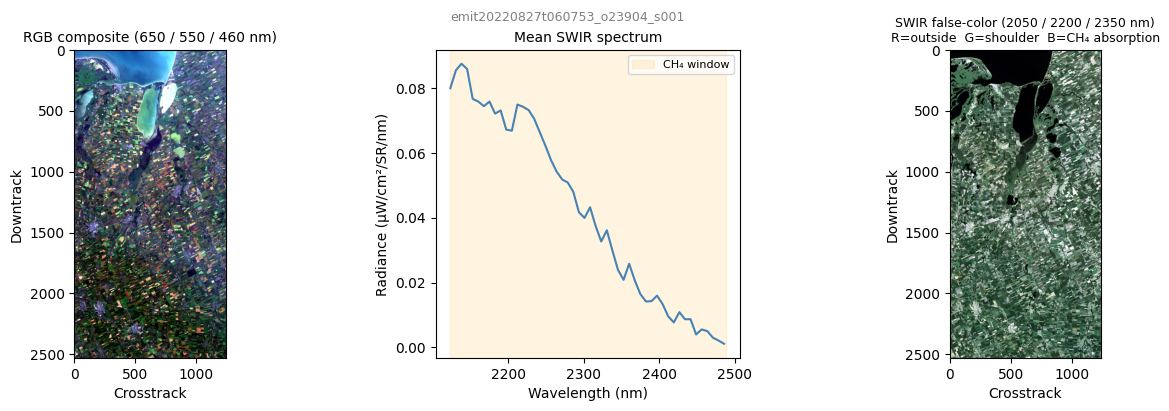

In [ ]:
fig = plt.figure(figsize=(16, 4))
gs  = gridspec.GridSpec(1, 3, width_ratios=[1.2, 1, 1.2], wspace=0.3)

# RGB composite: pick bands closest to 650, 550, 460 nm
rgb_idx = np.argmin(np.abs(wavelengths[:, None] - np.array([650, 550, 460])), axis=0)
rgb = rad.values[:, :, rgb_idx].astype(np.float32)

# 2-98 percentile stretch per channel
lo = np.nanpercentile(rgb, 2, axis=(0, 1))
hi = np.nanpercentile(rgb, 98, axis=(0, 1))
rgb = np.clip((rgb - lo) / (hi - lo), 0, 1)

ax0 = fig.add_subplot(gs[0])
ax0.imshow(rgb, origin="upper")
ax0.set_title("RGB composite (650 / 550 / 460 nm)", fontsize=10)
ax0.set_xlabel("Crosstrack")
ax0.set_ylabel("Downtrack")

# mean radiance spectrum over all pixels in the SWIR window
mean_spectrum = np.nanmean(rad_swir, axis=(0, 1))

ax1 = fig.add_subplot(gs[1])
ax1.plot(wavelengths[swir_idx], mean_spectrum, color="steelblue", lw=1.5)
ax1.axvspan(2122, 2488, alpha=0.12, color="orange", label="CH₄ window")
ax1.set_xlabel("Wavelength (nm)")
ax1.set_ylabel("Radiance (μW/cm²/SR/nm)")
ax1.set_title("Mean SWIR spectrum", fontsize=10)
ax1.legend(fontsize=8)

# SWIR false-color composite sensitive to methane
# R = 2050 nm (outside CH4 absorption), G = 2200 nm (shoulder), B = 2350 nm (deep inside absorption)
# a methane plume absorbs strongly at B -> appears yellowish
swir_rgb_wvl = np.array([2050, 2200, 2350])
swir_rgb_idx = np.argmin(np.abs(wavelengths[:, None] - swir_rgb_wvl), axis=0)
swir_rgb = rad.values[:, :, swir_rgb_idx].astype(np.float32)
lo2 = np.nanpercentile(swir_rgb, 2, axis=(0, 1))
hi2 = np.nanpercentile(swir_rgb, 98, axis=(0, 1))
swir_rgb = np.clip((swir_rgb - lo2) / (hi2 - lo2), 0, 1)

ax2 = fig.add_subplot(gs[2])
ax2.imshow(swir_rgb, origin="upper")
ax2.set_title("SWIR false-color (2050 / 2200 / 2350 nm)\nR=outside  G=shoulder  B=CH₄ absorption", fontsize=9)
ax2.set_xlabel("Crosstrack")
ax2.set_ylabel("Downtrack")

plt.suptitle("emit20220827t060753_o23904_s001", fontsize=9, color="gray")
plt.tight_layout()
plt.show()

## Methane retrieval with methanex

`methanex` is the retrieval module developed alongside this paper. It exposes four matched filter methods — from the simplest single-pass filter to the full iterative sparse algorithm with the rank-2 covariance update — all behind a single stateful engine and a unified `retrieve` API. The CH4 absorption template is loaded automatically from the TACO repository the first time the engine is initialised.


In [ ]:
#@title methanex module
"""
methanex — Methane column enhancement retrieval from imaging spectrometer data.

    eng = MethaneRetrieval(device="cuda")

    mf, R, meta = eng.retrieve(rad, MFConfig())
    mf, R, meta = eng.retrieve(rad, RMFConfig())
    mf, R, meta = eng.retrieve(rad, MAG1CConfig())
    mf, R, meta = eng.retrieve(rad, MAG1CFastConfig(tol=1e-5))

rad must be a torch.Tensor of shape (downtrack, crosstrack, bands).
retrieve() returns a RetrievalResult that supports both named access
and tuple unpacking (mf, albedo, metadata).

The CH4 absorption template for EMIT is loaded automatically from:
    https://data.source.coop/taco/methaneset/ch4_emit.safetensors
"""

import urllib.request
from dataclasses import dataclass, field
from pathlib import Path
from typing import Annotated, Any, Literal

import torch
import torch.nn.functional as F
from pydantic import BaseModel, Field
from safetensors.torch import load_file
from tqdm import tqdm


# Constants --------------------

SAFETENSORS_URL  = "https://data.source.coop/taco/methaneset/ch4_emit.safetensors"
SAFETENSORS_PATH = Path.home() / ".cache" / "methanex" / "ch4_emit.safetensors"
WAVELENGTH_RANGE = (2122, 2488)
EPSILON          = 1e-9
NODATA           = -9999


# Result container --------------------

@dataclass
class RetrievalResult:
    """Output of MethaneRetrieval.retrieve().

    Supports both named access and tuple unpacking:
        result = eng.retrieve(rad, config)
        result.mf, result.albedo, result.metadata

        mf, albedo, meta = eng.retrieve(rad, config)
        mf, albedo, _    = eng.retrieve(rad, config)
    """
    mf: torch.Tensor
    albedo: torch.Tensor
    metadata: dict[str, Any] = field(default_factory=dict)

    def __iter__(self):
        return iter((self.mf, self.albedo, self.metadata))

    def __getitem__(self, idx):
        return (self.mf, self.albedo, self.metadata)[idx]

    def __len__(self):
        return 3


# Config models --------------------

class BaseRetrievalConfig(BaseModel):
    """Parameters shared by all retrieval methods."""

    column_step: Annotated[int, Field(ge=1, description=(
        "Number of crosstrack columns processed together per engine call. "
        "column_step=1 is physically correct for push-broom sensors. "
        "Ignored when batch_size is set (forced to 1)."
    ))] = 1

    batch_size: Annotated[int | None, Field(ge=1, description=(
        "Number of independent columns processed in parallel. "
        "When set, column_step is forced to 1. "
        "NODATA pixels are filled with per-column mean and re-masked on output. "
        "None = legacy path with explicit NODATA filtering."
    ))] = None

    alpha: Annotated[float, Field(ge=0.0, le=1.0, description=(
        "Covariance diagonal regularisation weight. "
        "Small values (~1e-4) stabilise the Cholesky decomposition."
    ))] = 1e-4

    scaling: Annotated[float, Field(gt=0.0, description=(
        "Multiplicative factor applied to raw matched filter output. "
        "Default 1e5 maps EMIT radiance-scale retrievals to ~ppm·m."
    ))] = 1e5


class MFConfig(BaseRetrievalConfig):
    """Basic matched filter (no albedo correction)."""
    pass


class RMFConfig(BaseRetrievalConfig):
    """Albedo-corrected single-pass matched filter."""
    pass


class MAG1CConfig(BaseRetrievalConfig):
    """Iterative sparse matched filter (reference implementation)."""

    num_iter: Annotated[int, Field(ge=1, description=(
        "Number of reweighted-L1 iterations."
    ))] = 30

    covariance_update_scaling: Annotated[float, Field(ge=0.0, le=1.0, description=(
        "Fraction of estimated CH4 signal subtracted at each step. "
        "1.0 = full removal, 0.0 = no update."
    ))] = 1.0


class MAG1CFastConfig(MAG1CConfig):
    """Rank-2 accelerated iterative filter."""

    tol: Annotated[float | None, Field(ge=0.0, description=(
        "Early stopping on max per-column relative mf change. "
        "None = disabled, runs exactly num_iter steps."
    ))] = None

    outer_mode: Annotated[Literal["auto", "bmm", "einsum"], Field(description=(
        "How to compute the rank-2 correction. "
        "'auto' picks bmm when N < 2000 or device is CPU."
    ))] = "auto"


RetrievalConfig = MFConfig | RMFConfig | MAG1CConfig | MAG1CFastConfig

_DISPATCH: dict[type, str] = {
    MFConfig:        "mf",
    RMFConfig:       "rmf",
    MAG1CConfig:     "mag1c",
    MAG1CFastConfig: "mag1c_fast",
}


# Template helpers --------------------

def _download_template(url: str, dest: Path) -> None:
    print(f"Downloading CH4 template to {dest} ...")
    dest.parent.mkdir(parents=True, exist_ok=True)
    urllib.request.urlretrieve(url, dest)
    print("Download complete.")


def _load_template(path, wavelength_range, device, dtype):
    if not path.exists():
        _download_template(SAFETENSORS_URL, path)
    tensors   = load_file(str(path), device=device)
    centers   = tensors["centers"]
    template  = tensors["template"]
    band_mask = (centers >= wavelength_range[0]) & (centers <= wavelength_range[1])
    return template[band_mask].to(dtype), band_mask.cpu()


# NODATA helpers --------------------

def _fill_nodata(rad):
    """Replace NODATA pixels with per-column mean. Fully vectorized.

    Returns:
        filled:      Clone with NODATA replaced by per-column mean.
        nodata_mask: Bool (D, C), True where any band was NODATA.
        empty_cols:  Bool (C,), True for entirely-NODATA columns.
    """
    filled      = rad.clone()
    nodata_mask = (filled == NODATA).any(dim=-1)
    filled[nodata_mask] = 0.0

    counts     = (~nodata_mask).sum(dim=0)
    empty_cols = counts == 0

    col_sum  = filled.sum(dim=0, keepdim=True)
    col_mean = col_sum / counts.unsqueeze(0).clamp(min=1).unsqueeze(-1)
    filled[nodata_mask] = col_mean.expand_as(filled)[nodata_mask]

    return filled, nodata_mask, empty_cols


# Retrieval engine --------------------

class MethaneRetrieval:
    """Methane column enhancement retrieval engine."""

    def __init__(
        self,
        device: str | None = None,
        dtype: torch.dtype = torch.float32,
        wavelength_range: tuple[float, float] = WAVELENGTH_RANGE,
        safetensor_path: Path = SAFETENSORS_PATH,
        alpha: float = 1e-4,
        num_iter: int = 30,
    ):
        if device is None:
            device = "cuda" if torch.cuda.is_available() else "cpu"
        if dtype not in (torch.float32, torch.float64):
            raise ValueError("dtype must be torch.float32 or torch.float64")

        self.device   = device
        self.dtype    = dtype
        self.alpha    = alpha
        self.num_iter = num_iter
        self.template, self.band_mask = _load_template(
            safetensor_path, wavelength_range, device, dtype
        )

    # Internal helpers --------------------

    def _prepare(self, x):
        x = x.to(device=self.device, dtype=self.dtype)
        n_expected = int(self.band_mask.sum())
        if x.shape[-1] != n_expected:
            raise ValueError(
                f"x has {x.shape[-1]} bands but engine expects {n_expected}."
            )
        return x

    def _regularize(self, C, alpha):
        return C.lerp_(torch.diag_embed(torch.diagonal(C, dim1=-2, dim2=-1)), alpha)

    def _covariance(self, m_mu, N, alpha):
        C = torch.bmm(m_mu.transpose(1, 2), m_mu) / N
        return self._regularize(C, alpha)

    def _outer_correction(self, C_u, A, tp, beta, N, mode):
        if mode == "auto":
            mode = "bmm" if self.device == "cpu" or N < 2000 else "einsum"
        if mode == "bmm":
            P = torch.stack([A,   tp], dim=2)
            Q = torch.stack([-tp, beta.unsqueeze(1) * tp - A], dim=2)
            return C_u + torch.bmm(P, Q.transpose(1, 2))
        return (C_u
                - torch.einsum("bi,bj->bij", A,  tp)
                - torch.einsum("bi,bj->bij", tp, A)
                + beta[:, None, None] * torch.einsum("bi,bj->bij", tp, tp))

    def _core_filter(self, x, alpha):
        """Shared MF/RMF core: mean, covariance, Cholesky solve, albedo.

        Returns (x_mu, Cit, norm, R, mu, target).
        """
        N = x.shape[1]
        t = self.template.unsqueeze(0).unsqueeze(0)

        mu     = x.mean(dim=1, keepdim=True)
        target = t * mu
        x_mu   = x - mu

        C     = self._covariance(x_mu, N, alpha)
        cholC = torch.linalg.cholesky(C)
        Cit   = torch.cholesky_solve(target.transpose(1, 2), cholC)
        norm  = torch.bmm(target, Cit)
        R     = torch.bmm(x, mu.transpose(1, 2)) / torch.bmm(mu, mu.transpose(1, 2))

        return x_mu, Cit, norm, R, mu, target

    # Retrieval methods --------------------

    @torch.no_grad()
    def mf(self, x, alpha=None, scaling=1e5):
        """Basic matched filter (no albedo correction)."""
        x     = self._prepare(x)
        alpha = alpha if alpha is not None else self.alpha

        x_mu, Cit, norm, _, _, _ = self._core_filter(x, alpha)

        R  = torch.ones(x.shape[0], x.shape[1], 1,
                        device=self.device, dtype=self.dtype)
        mf = torch.bmm(x_mu, Cit) / norm.clamp_(min=EPSILON)
        return F.relu(mf) * scaling, R

    @torch.no_grad()
    def rmf(self, x, alpha=None, scaling=1e5):
        """Albedo-corrected single-pass matched filter."""
        x     = self._prepare(x)
        alpha = alpha if alpha is not None else self.alpha

        x_mu, Cit, norm, R, _, _ = self._core_filter(x, alpha)

        mf = torch.bmm(x_mu, Cit) / (R * norm.clamp_(min=EPSILON))
        return F.relu(mf) * scaling, R

    @torch.no_grad()
    def mag1c(self, x, num_iter=None, alpha=None,
              covariance_update_scaling=1.0, scaling=1e5):
        """Iterative sparse matched filter (reference MAG1C)."""
        x        = self._prepare(x)
        num_iter = num_iter if num_iter is not None else self.num_iter
        alpha    = alpha if alpha is not None else self.alpha
        N        = x.shape[1]
        t        = self.template.unsqueeze(0).unsqueeze(0)

        mf, R  = self.rmf(x, alpha=alpha, scaling=1.0)
        mu     = x.mean(dim=1, keepdim=True)
        target = t * mu

        for _ in range(num_iter):
            modx    = x - covariance_update_scaling * R * mf * target
            mu      = modx.mean(dim=1, keepdim=True)
            target  = t * mu
            modx_mu = modx - mu
            x_mu    = x - mu

            C     = self._covariance(modx_mu, N, alpha)
            cholC = torch.linalg.cholesky(C)
            Cit   = torch.cholesky_solve(target.transpose(1, 2), cholC)

            reg  = 1.0 / (R * (mf + EPSILON))
            norm = torch.bmm(target, Cit).clamp_(min=EPSILON)
            mf   = (torch.bmm(x_mu, Cit) - reg) / (R * norm)
            F.relu_(mf)

        return mf * scaling, R

    @torch.no_grad()
    def mag1c_fast(self, x, num_iter=None, alpha=None,
                   covariance_update_scaling=1.0, tol=None,
                   outer_mode="auto", scaling=1e5, _run_info=None):
        """Rank-2 accelerated iterative matched filter.

        When _run_info is a dict, convergence diagnostics are written into it:
            iterations_run, converged, final_rel_change.
        """
        x        = self._prepare(x)
        num_iter = num_iter if num_iter is not None else self.num_iter
        alpha    = alpha if alpha is not None else self.alpha
        N        = x.shape[1]
        t        = self.template.unsqueeze(0).unsqueeze(0)

        # base covariance — O(Ns²), paid once
        mu_src = x.mean(dim=1, keepdim=True)
        u      = x - mu_src
        C_u    = torch.bmm(u.transpose(1, 2), u) / N

        # init with single-pass RMF (raw scale)
        mf, R  = self.rmf(x, alpha=alpha, scaling=1.0)
        target = t * mu_src

        iters_run   = num_iter
        converged   = False
        rel_per_col = None

        for k in range(num_iter):
            d     = covariance_update_scaling * R * mf
            d_bar = d.mean(dim=1, keepdim=True)
            delta = d - d_bar

            # rank-2 correction — O(Ns) + O(s²)
            tp   = target.squeeze(1)
            A    = torch.bmm(delta.transpose(1, 2), u).squeeze(1) / N
            beta = (delta * delta).sum(dim=1).squeeze(-1) / N

            C = self._outer_correction(C_u, A, tp, beta, N, outer_mode)
            C = self._regularize(C, alpha)

            # mean update — O(s), shift computed before target update
            shift  = d_bar * target
            mu     = mu_src - shift
            target = t * mu

            cholC = torch.linalg.cholesky(C)
            Cit   = torch.cholesky_solve(target.transpose(1, 2), cholC)

            reg  = 1.0 / (R * (mf + EPSILON))
            norm = torch.bmm(target, Cit).clamp_(min=EPSILON)

            mf_prev = mf
            mf = (torch.bmm(u + shift, Cit) - reg) / (R * norm)
            F.relu_(mf)

            if tol is not None:
                rel_per_col = (mf - mf_prev).norm(dim=1) / (mf.norm(dim=1) + EPSILON)
                if rel_per_col.max() < tol:
                    iters_run = k + 1
                    converged = True
                    break

        if _run_info is not None:
            _run_info["iterations_run"]   = iters_run
            _run_info["converged"]        = converged
            if rel_per_col is not None:
                _run_info["final_rel_change"] = rel_per_col.detach()

        return mf * scaling, R

    # retrieve() public API --------------------

    def retrieve(self, rad, config, display_pbar=True):
        """Run retrieval over a full scene.

        Args:
            rad:    (downtrack, crosstrack, bands) radiance tensor.
            config: MFConfig | RMFConfig | MAG1CConfig | MAG1CFastConfig.

        Returns:
            RetrievalResult — supports tuple unpacking: mf, albedo, meta.
        """
        if not isinstance(rad, torch.Tensor):
            raise TypeError(f"rad must be a torch.Tensor, got {type(rad).__name__}")

        method_name = _DISPATCH[type(config)]
        method      = getattr(self, method_name)

        base_keys     = set(BaseRetrievalConfig.model_fields)
        method_kwargs = {k: v for k, v in config.model_dump().items() if k not in base_keys}
        method_kwargs["scaling"] = config.scaling

        if config.batch_size is not None:
            return self._retrieve_batched(
                rad, method, method_kwargs, config.batch_size,
                display_pbar, method_name
            )
        return self._retrieve_legacy(
            rad, method, method_kwargs, config.column_step,
            display_pbar, method_name
        )

    # Batched path --------------------

    def _retrieve_batched(self, rad, method, method_kwargs, batch_size,
                          display_pbar, method_name):
        rad = rad.to(device=self.device, dtype=self.dtype)
        D, C, s = rad.shape

        filled, nodata_mask, empty_cols = _fill_nodata(rad)
        data = filled.permute(1, 0, 2)

        mf_out     = torch.full((C, D), NODATA, device=self.device, dtype=self.dtype)
        albedo_out = torch.full((C, D), NODATA, device=self.device, dtype=self.dtype)

        valid_counts    = (~nodata_mask).sum(dim=0)
        batch_run_infos = []

        for col_start in tqdm(range(0, C, batch_size),
                              desc=f"retrieve [{method_name}]",
                              disable=not display_pbar):
            col_end = min(col_start + batch_size, C)

            if empty_cols[col_start:col_end].all():
                continue

            x = data[col_start:col_end]

            run_info = {} if method_name == "mag1c_fast" else None
            if run_info is not None:
                mf, R = method(x, **method_kwargs, _run_info=run_info)
                batch_run_infos.append(run_info)
            else:
                mf, R = method(x, **method_kwargs)

            mf_out    [col_start:col_end] = mf[:, :, 0]
            albedo_out[col_start:col_end] = R [:, :, 0]

        mf_out     = mf_out.T
        albedo_out = albedo_out.T
        mf_out    [nodata_mask] = NODATA
        albedo_out[nodata_mask] = NODATA

        n_bands  = int(self.band_mask.sum())
        metadata = {
            "method":       method_name,
            "n_downtrack":  D,
            "n_crosstrack": C,
            "n_bands":      n_bands,
            "device":       self.device,
            "dtype":        str(self.dtype),
            "valid_pixel_counts":      valid_counts.cpu(),
            "empty_columns":           empty_cols.nonzero(as_tuple=False).squeeze(-1).cpu(),
            "underdetermined_columns": (valid_counts < n_bands).nonzero(as_tuple=False).squeeze(-1).cpu(),
        }
        if batch_run_infos:
            metadata["batch_convergence"] = batch_run_infos

        return RetrievalResult(mf=mf_out, albedo=albedo_out, metadata=metadata)

    # Legacy path --------------------

    def _retrieve_legacy(self, rad, method, method_kwargs, column_step,
                         display_pbar, method_name):
        rad = rad.to(device=self.device, dtype=self.dtype)
        D, C, _ = rad.shape

        mf_out     = torch.full((D, C), NODATA, device=self.device, dtype=self.dtype)
        albedo_out = torch.full((D, C), NODATA, device=self.device, dtype=self.dtype)

        for col_start in tqdm(range(0, C, column_step),
                              desc=f"retrieve [{method_name}]",
                              disable=not display_pbar):
            col_end    = min(col_start + column_step, C)
            slice_data = rad[:, col_start:col_end, :]
            valid      = (slice_data != NODATA).all(dim=-1)

            if not valid.any():
                continue

            x     = slice_data[valid].unsqueeze(0)
            mf, R = method(x, **method_kwargs)

            mf_out    [:, col_start:col_end][valid] = mf[0, :, 0]
            albedo_out[:, col_start:col_end][valid] = R [0, :, 0]

        metadata = {
            "method":       method_name,
            "n_downtrack":  D,
            "n_crosstrack": C,
            "n_bands":      int(self.band_mask.sum()),
            "device":       self.device,
            "dtype":        str(self.dtype),
        }
        return RetrievalResult(mf=mf_out, albedo=albedo_out, metadata=metadata)

The engine loads the CH4 template once and keeps it in memory. Every retrieval call reuses the same template — only the config changes.

`column_step` controls how many crosstrack columns share background statistics per call. `column_step=1` is physically correct for push-broom sensors (each CCD column gets its own covariance). Larger values trade statistical correctness for speed.

`batch_size` controls how many independent columns are processed in parallel. When set, `column_step` is forced to 1 — each column keeps its own statistics, but multiple columns run simultaneously on the GPU. NODATA pixels are filled with the per-column mean before batching and re-masked in the output. This reduces kernel launches from 1242 to `ceil(1242 / batch_size)` with no change in retrieval output.

In [ ]:
eng        = MethaneRetrieval(device="cuda", dtype=torch.float64)
rad_swir_t = torch.from_numpy(rad_swir)

# basic matched filter — no albedo correction
mf_basic, R, _ = eng.retrieve(rad_swir_t, MFConfig(batch_size=64))

# albedo-corrected single-pass filter
mf_rmf, R, _   = eng.retrieve(rad_swir_t, RMFConfig(batch_size=64))

# full iterative filter — reference O(K·N·s²) implementation
mf_mag1c, R, _ = eng.retrieve(rad_swir_t, MAG1CConfig(batch_size=64))

# rank-2 accelerated filter — same output, O(N·s²) + O(K·N·s)
mf_fast, R, meta = eng.retrieve(rad_swir_t, MAG1CFastConfig(batch_size=64))

retrieve [mag1c_fast]: 100%|██████████| 20/20 [00:07<00:00,  2.74it/s]


The rank-2 accelerated filter produces numerically identical output to the reference MAG1C implementation. The reformulation is algebraically exact — no approximation is introduced.

In [ ]:
print(f"Mean diff: {(mf_mag1c - mf_fast).abs().mean().item():.10f} ppm·m")

Mean diff: 0.0000000027 ppm·m


## Retrieval results

Each panel shows the methane column enhancement in ppm·m over the full scene. From left to right: the basic matched filter without albedo correction, the albedo-corrected single-pass filter, the iterative MAG1C reference, and the rank-2 accelerated version.

Text(0.5, 1.01, 'Methane column enhancement — emit20220827t060753_o23904_s001')

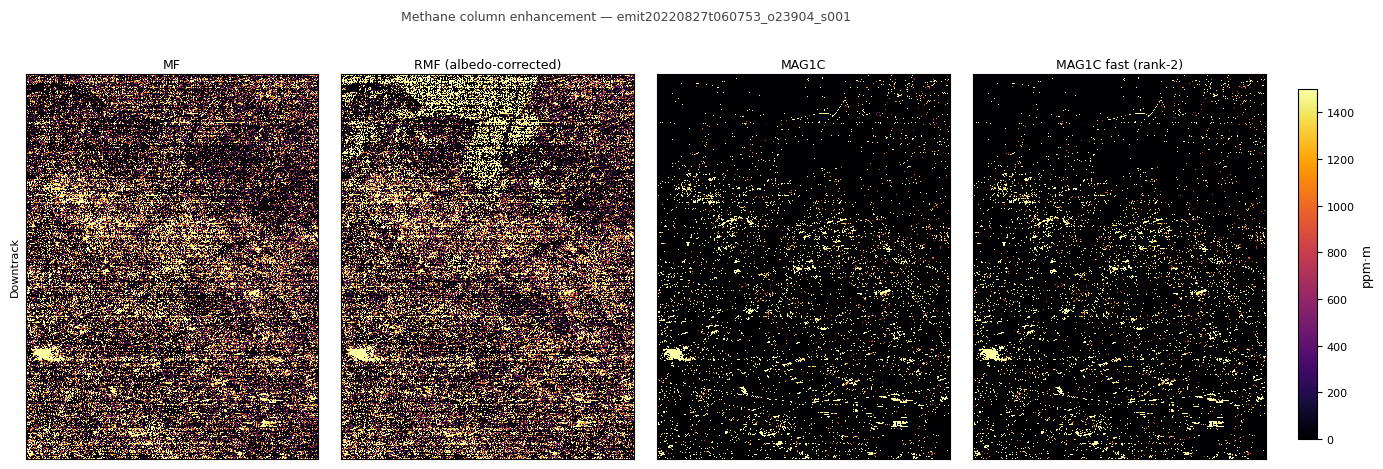

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

VMAX   = 1500   # ppm·m colorscale upper limit
CMAP   = "inferno"
TITLES = ["MF", "RMF (albedo-corrected)", "MAG1C", "MAG1C fast (rank-2)"]
MAPS   = [mf_basic, mf_rmf, mf_mag1c, mf_fast]

def to_plot(t):
    """Move to CPU numpy and mask NODATA."""
    a = t.cpu().numpy()
    return np.where(a == -9999, np.nan, a)

fig = plt.figure(figsize=(16, 5))
gs  = gridspec.GridSpec(1, 4, wspace=0.08)

axes = [fig.add_subplot(gs[i]) for i in range(4)]

for i, (ax, title, mf) in enumerate(zip(axes, TITLES, MAPS)):
    im = ax.imshow(to_plot(mf), cmap=CMAP, vmin=0, vmax=VMAX, origin="upper",
                   aspect="auto", interpolation="none")
    ax.set_title(title, fontsize=9, pad=4)
    ax.set_xticks([])
    if i == 0:
        ax.set_ylabel("Downtrack", fontsize=8)
        ax.set_yticks([])
    else:
        ax.set_yticks([])

# single shared colorbar on the right
cbar_ax = fig.add_axes([0.92, 0.15, 0.012, 0.7])
cb = fig.colorbar(im, cax=cbar_ax)
cb.set_label("ppm·m", fontsize=9)
cb.ax.tick_params(labelsize=8)

fig.suptitle(
    "Methane column enhancement — emit20220827t060753_o23904_s001",
    fontsize=9, y=1.01, color="#444444"
)

# 4. Experiments

We evaluate the proposed method on two complementary axes.

For **numerical correctness** we use synthetic CCD columns, which provide exact ground-truth comparisons and allow controlled variation of N and s.

For **wall-clock benchmarks** we use a real EMIT L1B granule (`20240604T140353`, 2528 downtrack pixels, 1242 crosstrack columns, s=50 SWIR bands in the 2122–2488 nm CH4 absorption window). We measure end-to-end retrieval time through the `retrieve()` API, with both methods using the same `batch_size` and NODATA handling (per-column mean fill). The only difference is the covariance computation: O(K·N·s²) for the reference vs O(N·s²) + O(K·N·s) for the rank-2 update.

All experiments use K=30 iterations and α=1e-4 following the default MAG1C configuration. Early stopping is disabled (`tol=None`) so both methods execute exactly K iterations — comparisons are pure algebraic identity checks. Experiments run in float32 and float64 on CPU and GPU.

### Numerical correctness on synthetic data

We generate synthetic CCD columns with covariance Σ = A·Aᵀ + 1e-3·I, A ~ N(0,1)^(s×s), shifted to positive values to match EMIT radiance. We fix s=50 and evaluate N ∈ {512, 1024, 2048} over 100 random seeds on both CPU and GPU.

In **float64** the error is exactly zero on both devices, confirming the rank-2 update is an algebraic identity. In **float32** the error varies by device due to differences in parallel reduction order and matmul precision (TF32 on GPU). The mean error stays below 5e-3 ppm·m on CPU; on GPU it may be slightly higher but remains negligible relative to the ~500 ppm·m detection threshold used in practice.

In [ ]:
import csv
import numpy as np
import torch

K       = 30
ALPHA   = 1e-4
SEEDS   = 100
NS      = [512, 1024, 2048]
CSV_OUT = "synthetic_correctness.csv"

devices = ["cpu"]
if torch.cuda.is_available():
    devices.append("cuda")

def make_columns(N, s, seed):
    rng  = np.random.default_rng(seed)
    A    = rng.standard_normal((s, s))
    Sig  = A @ A.T + 1e-3 * np.eye(s)
    L    = np.linalg.cholesky(Sig)
    data = rng.standard_normal((N, s)) @ L.T
    data += np.abs(data.min()) + 1.0
    return data.astype(np.float32)

rows = []
print(f"\n{'Device':<8} {'Precision':<10} {'N':<6} {'P99 err (ppm.m)':<22} {'Mean err (ppm.m)'}")
print("-" * 65)

for device in devices:
    for dtype in [torch.float64, torch.float32]:
        eng   = MethaneRetrieval(device=device, dtype=dtype)
        s     = int(eng.band_mask.sum())
        dname = "float64" if dtype == torch.float64 else "float32"

        for N in NS:
            p99_errs, mean_errs = [], []

            for seed in range(SEEDS):
                col = make_columns(N, s, seed)
                x   = torch.tensor(col[np.newaxis], dtype=dtype, device=device)

                mf_ref,  _ = eng.mag1c(x, num_iter=K, alpha=ALPHA)
                mf_fast, _ = eng.mag1c_fast(x, num_iter=K, alpha=ALPHA, tol=None)

                err = (mf_ref - mf_fast).abs().flatten()
                p99_errs.append(torch.quantile(err, 0.99).item())
                mean_errs.append(err.mean().item())

            p99  = np.mean(p99_errs)
            mean = np.mean(mean_errs)
            rows.append({"device": device, "dtype": dname, "N": N,
                         "p99_err": round(p99, 8), "mean_err": round(mean, 10)})
            print(f"{device:<8} {dname:<10} {N:<6} {p99:<22.2e} {mean:.2e}")

with open(CSV_OUT, "w", newline="") as f:
    w = csv.DictWriter(f, fieldnames=rows[0].keys())
    w.writeheader(); w.writerows(rows)
print(f"\nSaved {CSV_OUT}")


Device   Precision  N      P99 err (ppm.m)        Mean err (ppm.m)
-----------------------------------------------------------------
Download complete.
cpu      float64    512    3.86e-10               2.53e-11
cpu      float64    1024   2.55e-10               1.53e-11
cpu      float64    2048   1.25e-10               8.56e-12
cpu      float32    512    1.54e-01               1.16e-02
cpu      float32    1024   1.09e-01               7.04e-03
cpu      float32    2048   7.28e-02               4.46e-03
cuda     float64    512    2.43e-10               1.64e-11
cuda     float64    1024   1.10e-10               6.36e-12
cuda     float64    2048   9.27e-11               6.42e-12
cuda     float32    512    6.08e-02               3.87e-03
cuda     float32    1024   4.71e-02               2.67e-03
cuda     float32    2048   4.67e-02               3.52e-03

Saved synthetic_correctness.csv


### Wall-clock speedup on synthetic data

We benchmark both methods across a grid of column sizes N ∈ {512, 1024, 2048, 4096, 8192, 16384} and band counts s ∈ {50, 100, 150, 200, 285}, where s=50 approximates the EMIT SWIR window and s=285 the full instrument spectrum. Each configuration runs as a batch of 10 columns to amortize GPU kernel launch overhead. Results are averaged over 5 runs with 1 warmup.

The theoretical speedup is Ks/(s+K), which grows with s — from ~18.8× at s=50 to ~27.1× at s=285. In practice the empirical speedup is lower because the Cholesky factorisation and triangular solve — O(s³) per iteration, shared by both methods — are not accelerated by the reformulation.

In [ ]:
import time, csv
import numpy as np
import torch

K       = 30
ALPHA   = 1e-4
BATCH   = 10   # columns per call — amortizes GPU kernel launch overhead
RUNS    = 5
NS      = [512, 1024, 2048, 4096, 8192, 16384]
SS      = [50, 100, 150, 200, 285]
CSV_OUT = "synthetic_timing.csv"

def make_batch(N, s, batch):
    # random PSD covariance, same seed across all (N, s) for reproducibility
    rng  = np.random.default_rng(0)
    A    = rng.standard_normal((s, s))
    Sig  = A @ A.T + 1e-3 * np.eye(s)
    L    = np.linalg.cholesky(Sig)
    data = rng.standard_normal((batch, N, s)) @ L.T
    data += np.abs(data.min()) + 1.0
    return data.astype(np.float32)

def run_timed(fn, x, device, runs):
    fn(x)  # warmup x1
    if device == "cuda": torch.cuda.synchronize()
    times = []
    for _ in range(runs):
        if device == "cuda": torch.cuda.synchronize()
        t0 = time.perf_counter()
        fn(x)
        if device == "cuda": torch.cuda.synchronize()
        times.append(time.perf_counter() - t0)
    return np.mean(times) * 1000  # ms

devices = ["cpu"]
if torch.cuda.is_available():
    devices.append("cuda")

rows = []
print(f"\n{'Device':<8} {'Dtype':<10} {'N':<8} {'s':<6} {'mag1c (ms)':<14} {'fast (ms)':<14} {'speedup':<10} {'theory'}")
print("-" * 80)

for device in devices:
    for dtype in [torch.float32, torch.float64]:
        dname = "float64" if dtype == torch.float64 else "float32"

        for s in SS:
            # theoretical speedup Ks/(s+K) — depends only on s and K, not N
            theory = round(K * s / (s + K), 2)
            eng    = MethaneRetrieval(device=device, dtype=dtype)

            for N in NS:
                x = torch.tensor(make_batch(N, s, BATCH), dtype=dtype, device=device)

                # override template and band_mask so the engine accepts s bands
                eng.template  = torch.ones(s, device=device, dtype=dtype) / s**0.5
                eng.band_mask = torch.ones(s, dtype=torch.bool)

                ms_slow = run_timed(lambda x: eng.mag1c(x, num_iter=K, alpha=ALPHA), x, device, RUNS)
                ms_fast = run_timed(lambda x: eng.mag1c_fast(x, num_iter=K, alpha=ALPHA, tol=None), x, device, RUNS)
                speedup = round(ms_slow / ms_fast, 3)

                rows.append({"device": device, "dtype": dname, "N": N, "s": s,
                             "ms_mag1c": round(ms_slow, 3), "ms_fast": round(ms_fast, 3),
                             "speedup": speedup, "theory": theory})
                print(f"{device:<8} {dname:<10} {N:<8} {s:<6} {ms_slow:<14.1f} {ms_fast:<14.1f} {speedup:<10} {theory}")

with open(CSV_OUT, "w", newline="") as f:
    w = csv.DictWriter(f, fieldnames=rows[0].keys())
    w.writeheader(); w.writerows(rows)
print(f"\nSaved {CSV_OUT}")


Device   Dtype      N        s      mag1c (ms)     fast (ms)      speedup    theory
--------------------------------------------------------------------------------
cpu      float32    512      50     49.1           30.8           1.595      18.75
cpu      float32    1024     50     81.1           41.9           1.938      18.75
cpu      float32    2048     50     205.9          87.7           2.348      18.75
cpu      float32    4096     50     389.0          114.0          3.411      18.75
cpu      float32    8192     50     921.0          237.5          3.878      18.75
cpu      float32    16384    50     2027.8         594.3          3.412      18.75
cpu      float32    512      100    173.3          69.8           2.482      23.08
cpu      float32    1024     100    211.5          93.8           2.254      23.08
cpu      float32    2048     100    426.2          139.2          3.061      23.08
cpu      float32    4096     100    998.2          292.6          3.412      23.08
cpu 

## Wall-clock speedup on real EMIT data

We benchmark end-to-end retrieval on a real EMIT L1B granule (`20240604T140353`) through the `retrieve()` API. The full scene (2528 downtrack × 1242 crosstrack × 285 bands) is band-selected to the SWIR CH4 window (2122–2488 nm, s=50). Both methods use the same `batch_size` and NODATA handling (per-column mean fill) — the only difference is the covariance computation. Results are reported for float32 and float64 on CPU and GPU.

### Load EMIT + prepare SWIR batch

In [ ]:
import xarray as xr
import torch

FILE = "EMIT_L1B_RAD_001_20240604T140353_2415609_030.nc"

ds       = xr.open_dataset(FILE)
sbp      = xr.open_dataset(FILE, group="sensor_band_parameters")
rad_full = ds["radiance"].values
print(f"Scene shape: {rad_full.shape}")

eng_ref  = MethaneRetrieval(device="cpu", dtype=torch.float32)
rad_swir = torch.from_numpy(rad_full[:, :, eng_ref.band_mask.numpy()])
print(f"SWIR shape: {rad_swir.shape}  (downtrack, crosstrack, s)")

Scene shape: (2528, 1242, 285)
Download complete.
SWIR shape: torch.Size([2528, 1242, 50])  (downtrack, crosstrack, s)


### Benchmark MAG1C vs MAG1C-fast on real EMIT data.

In [ ]:
import time, csv
import torch
import pandas as pd
from tqdm import tqdm

K          = 30
BATCH_SIZE = 64
CSV_OUT    = "bench_results.csv"

configs = [("cpu", torch.float32), ("cpu", torch.float64)]
if torch.cuda.is_available():
    configs += [("cuda", torch.float32), ("cuda", torch.float64)]

rows = []
for device, dtype in tqdm(configs, desc="experiments"):
    dname = "float32" if dtype == torch.float32 else "float64"
    tqdm.write(f"\n{'='*60}")
    tqdm.write(f"Device: {device.upper()}  dtype: {dname}")
    tqdm.write(f"{'='*60}")

    eng = MethaneRetrieval(device=device, dtype=dtype)
    rad = rad_swir_t.to(device=device, dtype=dtype)

    if device == "cuda": torch.cuda.synchronize()
    t0 = time.perf_counter()
    mf_slow, _, _ = eng.retrieve(rad, MAG1CConfig(batch_size=BATCH_SIZE, num_iter=K))
    if device == "cuda": torch.cuda.synchronize()
    ms_slow = (time.perf_counter() - t0) * 1000
    tqdm.write(f"  MAG1C:      {ms_slow:.1f} ms")

    if device == "cuda": torch.cuda.synchronize()
    t0 = time.perf_counter()
    mf_fast, _, _ = eng.retrieve(rad, MAG1CFastConfig(batch_size=BATCH_SIZE, num_iter=K, tol=None))
    if device == "cuda": torch.cuda.synchronize()
    ms_fast = (time.perf_counter() - t0) * 1000
    tqdm.write(f"  MAG1C-fast: {ms_fast:.1f} ms")

    speedup = ms_slow / ms_fast
    valid = (mf_slow != NODATA) & (mf_fast != NODATA)
    diff  = (mf_slow[valid] - mf_fast[valid]).abs()
    mae   = diff.mean().item()
    p99   = diff.quantile(0.99).item()

    tqdm.write(f"  Speedup:    {speedup:.2f}x")
    tqdm.write(f"  MAE:        {mae:.6f} ppm·m")
    tqdm.write(f"  P99:        {p99:.6f} ppm·m")

    rows.append({
        "device":    device,
        "dtype":     dname,
        "ms_mag1c":  round(ms_slow, 2),
        "ms_fast":   round(ms_fast, 2),
        "speedup":   round(speedup, 3),
        "mae_ppm_m": round(mae, 5),
        "p99_ppm_m": round(p99, 5),
    })

with open(CSV_OUT, "w", newline="") as f:
    w = csv.DictWriter(f, fieldnames=rows[0].keys())
    w.writeheader(); w.writerows(rows)

print(f"\n\nSaved {CSV_OUT}\n")
print(pd.read_csv(CSV_OUT).to_markdown(index=False))

experiments:   0%|          | 0/4 [00:00<?, ?it/s]


Device: CPU  dtype: float32



experiments:   0%|          | 0/4 [03:20<?, ?it/s]

  MAG1C:      200982.7 ms



experiments:   0%|          | 0/4 [04:57<?, ?it/s]

  MAG1C-fast: 96605.8 ms


experiments:  25%|██▌       | 1/4 [04:57<14:53, 297.94s/it]

  Speedup:    2.08x
  MAE:        0.143028 ppm·m
  P99:        2.103271 ppm·m

Device: CPU  dtype: float64



experiments:  25%|██▌       | 1/4 [10:50<14:53, 297.94s/it]

  MAG1C:      352339.9 ms



experiments:  25%|██▌       | 1/4 [13:31<14:53, 297.94s/it]

  MAG1C-fast: 160162.4 ms


experiments:  50%|█████     | 2/4 [13:31<14:09, 424.72s/it]

  Speedup:    2.20x
  MAE:        0.000000 ppm·m
  P99:        0.000000 ppm·m

Device: CUDA  dtype: float32



experiments:  50%|█████     | 2/4 [13:43<14:09, 424.72s/it]

  MAG1C:      10778.9 ms



experiments:  75%|███████▌  | 3/4 [13:48<03:58, 238.69s/it]

  MAG1C-fast: 5577.7 ms
  Speedup:    1.93x
  MAE:        1.092183 ppm·m
  P99:        17.714508 ppm·m

Device: CUDA  dtype: float64



experiments:  75%|███████▌  | 3/4 [14:07<03:58, 238.69s/it]

  MAG1C:      16860.4 ms



experiments: 100%|██████████| 4/4 [14:14<00:00, 213.75s/it]


  MAG1C-fast: 7312.8 ms
  Speedup:    2.31x
  MAE:        0.000000 ppm·m
  P99:        0.000000 ppm·m


Saved bench_results.csv

| device   | dtype   |   ms_mag1c |   ms_fast |   speedup |   mae_ppm_m |   p99_ppm_m |
|:---------|:--------|-----------:|----------:|----------:|------------:|------------:|
| cpu      | float32 |   200983   |  96605.8  |     2.08  |     0.14303 |     2.10327 |
| cpu      | float64 |   352340   | 160162    |     2.2   |     0       |     0       |
| cuda     | float32 |    10778.9 |   5577.74 |     1.932 |     1.09218 |    17.7145  |
| cuda     | float64 |    16860.4 |   7312.81 |     2.306 |     0       |     0       |


### Hardware

All experiments run on Google Colab. The following cell reports the runtime specs.

In [ ]:
# GPU
!nvidia-smi --query-gpu=name,memory.total,driver_version --format=csv,noheader

# CPU
!lscpu | grep "Model name"

# RAM
!free -h | grep Mem

# PyTorch + CUDA
import torch
print(f"PyTorch {torch.__version__}")
print(f"CUDA {torch.version.cuda}")

Tesla T4, 15360 MiB, 580.82.07
Model name:                              Intel(R) Xeon(R) CPU @ 2.00GHz
Mem:            12Gi       942Mi       8.1Gi       1.0Mi       3.6Gi        11Gi
PyTorch 2.10.0+cu128
CUDA 12.8


### Scaling analysis

The following cell plots the empirical speedup vs the theoretical bound from the `synthetic_timing.csv` results. Data is hardcoded to avoid file I/O.

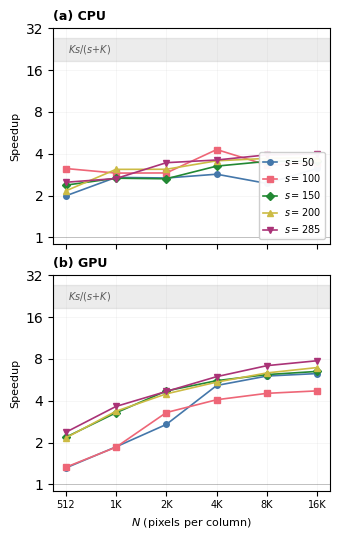

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

data = {
    ("cpu", "float64"): {
        50:  {"N": [512, 1024, 2048, 4096, 8192, 16384], "speedup": [1.99, 2.705, 2.677, 2.851, 2.445, 3.143]},
        100: {"N": [512, 1024, 2048, 4096, 8192, 16384], "speedup": [3.133, 2.904, 2.911, 4.29, 3.315, 3.417]},
        150: {"N": [512, 1024, 2048, 4096, 8192, 16384], "speedup": [2.377, 2.668, 2.643, 3.261, 3.528, 3.565]},
        200: {"N": [512, 1024, 2048, 4096, 8192, 16384], "speedup": [2.159, 3.089, 3.094, 3.561, 3.705, 3.759]},
        285: {"N": [512, 1024, 2048, 4096, 8192, 16384], "speedup": [2.494, 2.653, 3.451, 3.608, 3.93, 3.984]},
    },
    ("cuda", "float64"): {
        50:  {"N": [512, 1024, 2048, 4096, 8192, 16384], "speedup": [1.311, 1.862, 2.701, 5.152, 6.025, 6.277]},
        100: {"N": [512, 1024, 2048, 4096, 8192, 16384], "speedup": [1.327, 1.852, 3.289, 4.068, 4.523, 4.711]},
        150: {"N": [512, 1024, 2048, 4096, 8192, 16384], "speedup": [2.181, 3.276, 4.704, 5.579, 6.173, 6.503]},
        200: {"N": [512, 1024, 2048, 4096, 8192, 16384], "speedup": [2.157, 3.362, 4.483, 5.448, 6.345, 6.935]},
        285: {"N": [512, 1024, 2048, 4096, 8192, 16384], "speedup": [2.368, 3.64, 4.667, 5.965, 7.158, 7.766]},
    },
}

K = 30
theory = {s: K * s / (s + K) for s in [50, 100, 150, 200, 285]}
colors  = {50: "#4477AA", 100: "#EE6677", 150: "#228833", 200: "#CCBB44", 285: "#AA3377"}
markers = {50: "o", 100: "s", 150: "D", 200: "^", 285: "v"}

# --- single-column IEEE Letters width: ~3.5 in; two rows ---
fig, axes = plt.subplots(2, 1, figsize=(3.5, 5.5), sharex=True, sharey=True)

for ax, (device, label) in zip(axes, [("cpu", "CPU"), ("cuda", "GPU")]):
    for s in [50, 100, 150, 200, 285]:
        d = data[(device, "float64")][s]
        ax.plot(d["N"], d["speedup"], marker=markers[s], color=colors[s],
                label=f"$s={s}$", markersize=4, lw=1.2, zorder=3)

    ax.set_xscale("log", base=2)
    ax.set_yscale("log", base=2)
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda v, _: f"{v:g}"))
    ax.set_ylabel("Speedup", fontsize=8)
    ax.set_title(f"({['a','b'][list(dict(zip(axes,[('cpu','CPU'),('cuda','GPU')])).keys()).index(ax)]}) {label}",
                 fontsize=9, fontweight="bold", loc="left")
    ax.set_yticks([1, 2, 4, 8, 16, 32])
    ax.set_ylim(0.9, 32)
    ax.axhline(1, color="k", lw=0.5, alpha=0.3)
    ax.grid(True, which="both", alpha=0.15, lw=0.5)

    t_min = theory[50]
    t_max = theory[285]
    ax.axhspan(t_min, t_max, alpha=0.15, color="gray", zorder=0)
    ax.text(530, t_max * 0.92, r"$Ks/(s{+}K)$",
            fontsize=7, color="0.35", va="top", style="italic")

# x-axis only on bottom panel
axes[1].set_xticks([512, 1024, 2048, 4096, 8192, 16384])
axes[1].set_xticklabels(["512", "1K", "2K", "4K", "8K", "16K"], fontsize=7)
axes[1].set_xlabel("$N$ (pixels per column)", fontsize=8)

# shared legend inside top panel
axes[0].legend(fontsize=7, loc="lower right", framealpha=0.95,
               handlelength=1.4, columnspacing=0.6, ncol=1)

plt.tight_layout(h_pad=0.6)
plt.savefig("scaling_speedup.pdf", bbox_inches="tight", dpi=300)
plt.show()